In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm 
import os 
from glob import glob 
import pickle
import cv2

# 초기 세팅 

In [2]:
image_size= 256 
image_channels =3

# 데이터 로드 

In [ ]:
!unzip '/content/drive/MyDrive/데이터공유폴더.lnk/생육환경최적화.zip'

Archive:  /content/drive/MyDrive/데이터공유폴더.lnk/생육환경최적화.zip
  inflating: sample_submission.csv   
   creating: test/
   creating: test/image/
  inflating: test/image/001.png      
  inflating: test/image/002.png      
  inflating: test/image/003.png      
  inflating: test/image/004.png      
  inflating: test/image/005.png      
  inflating: test/image/006.png      
  inflating: test/image/007.png      
  inflating: test/image/008.png      
  inflating: test/image/009.png      
  inflating: test/image/010.png      
  inflating: test/image/011.png      
  inflating: test/image/012.png      
  inflating: test/image/013.png      
  inflating: test/image/014.png      
  inflating: test/image/015.png      
  inflating: test/image/016.png      
  inflating: test/image/017.png      
  inflating: test/image/018.png      
  inflating: test/image/019.png      
  inflating: test/image/020.png      
  inflating: test/image/021.png      
  inflating: test/image/022.png      
  in

In [ ]:
folder_dir = glob('/content/train/*')
folder_dir.sort()

In [ ]:
image_dir_lst = [] 
csv_dir_lst = []
label_dir_lst = [] 

for folder in folder_dir:
  image_dir = glob(os.path.join(folder,'image','*.png'))
  image_dir.extend(glob(os.path.join(folder,'image','*.jpg')))
  image_dir_lst.extend(image_dir)

  csv_dir = glob(os.path.join(folder,'meta','*.csv'))
  csv_dir_lst.extend(csv_dir)

  label_df = pd.read_csv(folder + '/label.csv')
  label_dir_lst.extend(np.array(label_df))
 
image_dir_lst.sort()
csv_dir_lst.sort()
label_dir_lst = np.array(pd.DataFrame(label_dir_lst).sort_values(by=0))

In [ ]:
df = pd.DataFrame([image_dir_lst,csv_dir_lst,label_dir_lst[:,1]]).T
df.columns = ['IMG_DIR','META_DIR','LEAF_WEIGHT']
df['LEAF_WEIGHT'] = df['LEAF_WEIGHT'].map(float)

image_size = 2464,3280

# 데이터 제너레이터

## META 데이터 

In [ ]:
columns = ['내부온도관측치'	,'외부온도관측치',	'내부습도관측치']

### 스케일링

In [ ]:
def find_minmax_value(csv_dir):
  csv = pd.read_csv(csv_dir)
  csv = csv[columns]
  csv = csv.dropna()
  min = np.min(csv,axis=0).values.astype(np.float16)
  max = np.max(csv,axis=0).values.astype(np.float16)
  return min,max 

# min_lst = [] 
# max_lst = []   

# n = 0 
# for csv_dir in csv_dir_lst:
#   min,max = find_minmax_value(csv_dir)
#   if pd.isna(min[0]):
#     print(csv_dir)
#     n+=1
    
#   min_lst.append(min)
#   max_lst.append(max)

  

In [ ]:
# key_arange= np.arange(len(image_dir_lst))

# batch_key_arange = key_arange[0:32]

# key = batch_key_arange[0]

# def preproess_csv(key):
#   csv = pd.read_csv(csv_dir_lst[key])
#   csv = np.array(csv[].dropna().sample(20).reset_index().sort_values(by=['index']).drop(columns='index'))
#   return csv 

## 이미지 데이터 

In [ ]:
from albumentations.augmentations.transforms import VerticalFlip,Transpose,GaussNoise,Normalize,RandomGamma,SmallestMaxSize,GridDistortion,Rotate,HorizontalFlip
from albumentations.augmentations.transforms import RandomBrightnessContrast,Transpose,CLAHE,LongestMaxSize
def image_augmentation(normal_image):
  import albumentations as A
  transform = A.Compose([
                         VerticalFlip(),
                         Rotate(),
                         HorizontalFlip()
  ])
  augmentated_image = transform(image= normal_image)['image']
  return augmentated_image
  
def img_preprocess(img,augmentation):
  if augmentation:
    img = image_augmentation(img)
  img = cv2.resize(img,dsize=(image_size,image_size)) #resize Albu mentations -> vision 관련 augmentation document 
  img = img/255.
  return img 

def make_batch_img(batch_df_img_dir,augmentation):
  batch_imgs = np.zeros(len(batch_df_img_dir)*image_size*image_size*image_channels).reshape(-1,image_size,image_size,image_channels)
  for n,img_dir in enumerate(batch_df_img_dir):
    img = cv2.imread(img_dir)
    img = img_preprocess(img,augmentation)
    batch_imgs[n,:,:,:] = img
  return batch_imgs

## 라벨 

In [ ]:
def label_scailng(temp_batch_label):
  global min,max
  return_value = (temp_batch_label-min)/(max-min)
  return return_value 
def init_minmax(df):
  min = np.min(df['LEAF_WEIGHT'],axis=0)
  max = np.max(df['LEAF_WEIGHT'],axis=0)
  return min,max

## 제너레이터 

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import Sequence
import math

class DataGenerator(Sequence):
  def __init__(self,df,
                 batch_size: int,
               shuffle : bool = False,
               augmentation : bool = False):
        self.shuffle = shuffle 
        self.df = df  
        self.batch_size = batch_size
        self.augmentation = augmentation
        

        
  def __len__(self):
    return math.ceil(len(self.df) / self.batch_size)

  def on_epoch_end(self):
    self.indices = np.arange(len(self.df))
    if self.shuffle == True:
      np.random.shuffle(self.indices)
      self.df = self.df.iloc[self.indices]
    
  def __getitem__(self, index):
    self.batch_df = self.df.iloc[index*self.batch_size:(index+1)*self.batch_size]

    batch_img = make_batch_img(self.batch_df['IMG_DIR'].values,self.augmentation)

    batch_label = self.batch_df['LEAF_WEIGHT'].values
    batch_label = label_scailng(batch_label)


    return batch_img.astype(float), batch_label

# 모델

In [ ]:
from tensorflow.keras import optimizers
from tensorflow.keras.metrics import Recall
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import  Activation, AveragePooling2D
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Activation,Dense,Flatten
from tensorflow.keras.layers import BatchNormalization, Input, Dropout,Reshape
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.applications import VGG19,EfficientNetV2S, ResNet50V2, vgg19,resnet_v2
import math
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from keras.layers.pooling import GlobalAveragePooling2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay

In [ ]:
effv2 = EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(image_size, image_size,3)) #size -> 256, 256 
effv2.trainable = False

82436096/82420632 [==============================] - 2s 0us/step


In [ ]:
def conv_layer(filter,image_input):
  x = Conv2D(filter, (2,2), padding ='same')(image_input)
  x = BatchNormalization()(x)
  x = Dropout(0.2)(x)
  x = MaxPooling2D()(x)
  return x 

In [ ]:
def make_model(img_input):
  img = effv2(img_input)
  for i in [512,128,32]:
    img = conv_layer(i,img)

  img = GlobalAveragePooling2D()(img)
  img = Dense(1,activation = 'sigmoid')(img)
  model = Model(img_input,img)
  return model 

## Compile

In [ ]:
!pip install tensorflow-addons
import tensorflow_addons as tfa

initial_learning_rate = 0.0005
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

optimizer = tfa.optimizers.RectifiedAdam(
    learning_rate=lr_schedule,
    total_steps=10000,
    warmup_proportion=0.1,
    min_lr=1e-5,
)

     |████████████████████████████████| 1.1 MB 15.3 MB/s 


In [ ]:
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

## 콜백 

In [ ]:
from tensorflow.keras.callbacks import Callback
from IPython.display import clear_output
class PlotLosses(Callback):
  def on_train_begin(self, logs={}):
    self.epochs = []
    self.losses = []
    self.val_losses = []
    self.logs = []
    self.fig = plt.figure()

  def on_epoch_end(self, epoch, logs={}):
    

    self.epochs.append(epoch)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))

    clear_output(wait=True)
    plt.plot(self.epochs, self.losses, label="loss")
    plt.plot(self.epochs, self.val_losses, label="val_loss")
    plt.legend()
    plt.show();
    print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])
plot_losses = PlotLosses()

from tensorflow.keras.callbacks import ModelCheckpoint #<- model 저장 객체, best_model.h5라는 모델 이 저장 됨 
model_check_point = ModelCheckpoint(
    '/content/drive/MyDrive/Colab Notebooks/Hanyang_repo/생육환경최적화/model/model.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True)

#call backs 선언


## wandb

In [ ]:
!pip install wandb
import wandb 
from wandb.keras import WandbCallback
wandb.init(project="Dacon_생육", entity="crimama-",name='baseline_0421')
wandb.config = {
  "learning_rate": lr_schedule,
  "epochs": 200,
  "batch_size": 128
}

# ... Define a model

## 학습 

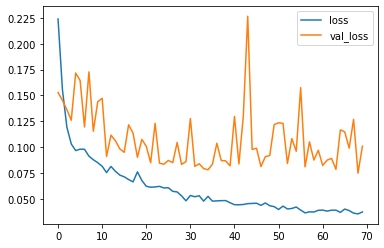

loss =  0.037389714270830154 , val_loss =  0.10095783323049545
46/46 [==============================] - 349s 8s/step - loss: 0.0374 - mse: 0.0043 - val_loss: 0.1010 - val_mse: 0.0199 - _timestamp: 1650494304.0000 - _runtime: 24394.0000
Epoch 71/150
36/46 [======================>.......] - ETA: 1:08 - loss: 0.0371 - mse: 0.0045

In [ ]:
#Train - Valid 분할 
train_df = df[:1450]
valid_df = df[1450:]

#min,max 
min,max = init_minmax(train_df)
#제너레이터 

train_generator = DataGenerator(train_df,
                                batch_size = 32,
                                shuffle = True,
                                augmentation = True)
valid_generator = DataGenerator(valid_df,
                                batch_size=32,
                                shuffle = False,
                                augmentation = False)

#콜백 
callbacks = [plot_losses,WandbCallback()]

#모델 선언 
img_input = Input((image_size,image_size,image_channels))
model = make_model(img_input) 

model.compile(optimizer=optimizer,loss = root_mean_squared_error,metrics = ['mse'])
history = model.fit(train_generator,validation_data = valid_generator, epochs=150,verbose=1,callbacks=callbacks)

# submission 

## 테스트 제너레이터

In [ ]:
test_dir = glob('/content/test/image/*')
test_dir.sort()
submission = pd.read_csv('/content/sample_submission.csv')

In [ ]:
test_key_arange = np.arange(len(test_dir))

In [ ]:
def test_img_preprocess(img):
  img = cv2.resize(img,dsize=(image_size,image_size)) #resize Albu mentations -> vision 관련 augmentation document 
  img = img/255.
  return img 

def test_make_batch_img(image_dir,batch_key_arange):
  batch_imgs = [] 
  for key in batch_key_arange:
    img_dir = image_dir[key]
    img = cv2.imread(img_dir)
    img = test_img_preprocess(img)
    batch_imgs.append(img)
  batch_imgs = np.array(batch_imgs).astype(float)
  return batch_imgs

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import Sequence
import math

class TestDataGenerator(Sequence):
  def __init__(self,key_arange,
                 batch_size: int,
               shuffle : bool = False,
               augmentation : bool = False):
        self.shuffle = shuffle 
        self.key_arange = key_arange       
        self.batch_size = batch_size
        self.augmentation = augmentation
        

  def __len__(self):
    return math.ceil(len(self.key_arange) / self.batch_size)

    
  def __getitem__(self, index):
    self.batch_key_arange = self.key_arange[index*self.batch_size:(index+1)*self.batch_size]

    batch_img = test_make_batch_img(test_dir,self.batch_key_arange)
    

    return batch_img


In [ ]:
test_generator = TestDataGenerator(test_key_arange,32)
y_ = model.predict(test_generator)
predicted = y_*(max-min) + min 
submission['leaf_weight'] = predicted.squeeze()
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/Hanyang_repo/생육환경최적화/submission.csv',index=False)

In [ ]:
def NMAE(true, pred):
    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))
    return score